In [22]:
from matplotlib.dates import DateFormatter
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib as mpl
import matplotlib.cm as mplcm
import matplotlib.colors as colors
import pandas as pd
import numpy as np
import os
import datetime as dt
from datetime import datetime,timedelta
import matplotlib.ticker as ticker
from matplotlib.ticker import LinearLocator
import topf

%matplotlib inline
mpl.rcParams["axes.labelsize"] = 24
mpl.rcParams["axes.titlesize"] = 24
mpl.rcParams["xtick.labelsize"] = 18
mpl.rcParams["ytick.labelsize"] = 22
mpl.rcParams["lines.linewidth"] = 2
mpl.rcParams["legend.fontsize"] = 17
mpl.rcParams["xtick.direction"] = "in"
mpl.rcParams["ytick.direction"] = "in"
mpl.rcParams["font.family"] = "serif"
mpl.rcParams["image.cmap"] = "viridis"

ROOT_DIR = os.path.dirname(os.path.dirname(os.path.abspath("__file__")))
RESULTS_DIR = os.path.join(ROOT_DIR, "results")
RESULTS_DIR_F = os.path.join(ROOT_DIR, "results_filtered")


In [23]:
def persistent_filter(data_df, limit):
    filtered_df = data_df.loc[:, data_df.max() >= limit].copy()
    topics = [int(column.split("_")[1]) for column in filtered_df.columns]
    for topic in topics:
        topic_arr = filtered_df[f"Topic_{topic}"].to_numpy()
        topic_arr_indexed = np.column_stack((np.arange(topic_arr.shape[0]), topic_arr))
        transformer = topf.PersistenceTransformer()  # prepare transformer
        persistence = transformer.fit_transform(topic_arr_indexed)      # transform data into peaks
        peaks = np.copy(persistence)
        threshold = np.max(topic_arr_indexed[:, 1]) / 2
        peaks[peaks[:, 1] < threshold] = -5
        new_cols = {
            f"persistence_{topic}": persistence[:, 1],
            f"peaks_{topic}": peaks[:, 1],
            f"threshold_{topic}": threshold,
        }
        filtered_df = pd.concat([filtered_df, pd.DataFrame(new_cols, index=filtered_df.index)], axis=1)
    return filtered_df, topics

In [24]:
def multi_line_peaks_plot(df, title, threshold):
    topics = [col for col in df.columns if col.startswith("Topic_")]
    series = [df[topic] for topic in topics]
    fig, ax = plt.subplots(figsize=(25, 7))
    beginning, end = dt.date(2022, 1, 1), dt.date(2023,1,1)
    cm = plt.get_cmap('nipy_spectral')
    topic_count = len(series)
    cNorm  = colors.Normalize(vmin=0, vmax=topic_count-1)
    scalarMap = mplcm.ScalarMappable(norm=cNorm, cmap=cm)
    color_list = [scalarMap.to_rgba(i) for i in range(0,topic_count)]

    for data, color, topic in zip(series, color_list, topics):
        if max(data) >= threshold:
            ax.plot(data.index.values, data, color=color, lw=0.8, alpha=0.7, label=topic)
            
    ax.set(title=title, xbound=(beginning, end),ylim=(0))
    ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%b-%y"))
    ax.get_xaxis().set_tick_params(which='both', rotation=0)

    ticks = [tick for tick in ax.xaxis.get_majorticklabels()]
    ticks[0].set_horizontalalignment("left")
    ticks[-1].set_horizontalalignment("right")
    return fig


In [25]:
def filtered_multi_lines_peaks_plot(df):
    fig, ax = plt.subplots(figsize=(25, 7))
    beginning = dt.date(2022, 1, 1)
    end = dt.date(2023,1,1)
    title = "Filtered Topic Peaks"

    colors = {
        "red":[15, 40, 49, 72, 56, 61, 65, 68, 72, 97, 107, 159, 177, 180, 181, 185],
        "blue":[0, 12, 35, 39,41, 50, 80, 115, 122, 136, 161, 163, 166],
        "magenta":[9, 31, 44, 87, 95, 164, 169, 194],
        "green":[19, 81, 117, 134, 149]
    }
    labels = {
        "red":"Advances, Battles, Attacks and Effects of War",
        "blue":"Politics",
        "magenta":"Prices, Supply Chain and Sanctions",
        "green":"Artillery and Troops",
    }

    uniques = []
    topic_data, topics = persistent_filter(df,25)
    for topic in topics:
        mask = [-5 if num <= 0 else 1 for num in topic_data[f"peaks_{topic}"]]
        signals = topic_data[f"Topic_{topic}"].mul(mask)
        signals = [num if num > 0 else -5 for num in signals]
        color = None
        for i in colors.items():
            if topic in i[1]:
                color = i[0]
                label = labels[color]
                if color not in uniques:
                    uniques.append(color)
                else:
                    label = None
                break
        ax.scatter(topic_data.index.values, signals, c=color, s=25)
        ax.vlines(topic_data.index.values, [0]*len(signals), signals, label=label, colors=color, linewidth=1)

    ax.set(title=title, xbound=(beginning, end), ylim=(0))
    date_form = DateFormatter("%b-%y")
    ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
    ax.xaxis.set_major_formatter(date_form)
    ax.legend(loc='upper right', bbox_to_anchor=(1, 1))
    ticks = [tick for tick in ax.xaxis.get_majorticklabels()]
    ticks[0].set_horizontalalignment("left")
    ticks[-1].set_horizontalalignment("right")

    handles, labels = plt.gca().get_legend_handles_labels()
    order = [2,1,3,0]
    L = ax.legend([handles[idx] for idx in order],[labels[idx] for idx in order])
    plt.setp(L.texts, family='Arial') 
    L.get_frame().set_linewidth(0.0)
    for legobj in L.legendHandles:
        legobj.set_linewidth(2)

    plt.show()
    
    return fig

In [26]:
def category_plot(df, chosen_cat, clist, tuples, columns):

    cats = {
        "bat":[15, 40, 49, 72, 56, 61, 65, 68, 72, 97, 107, 159, 177, 180, 181, 185],
        "pol":[0, 12, 35, 39, 41, 50, 80, 115, 122, 136, 161, 163, 166],
        "pri":[9, 31, 44, 95, 164, 169, 194],
        "art":[19, 81, 117, 134, 149]
    }
    
    cat_topics = cats.get(chosen_cat)
    if not cat_topics:
        return None

    fig, ax = plt.subplots(figsize=(25, 7))
    beginning = dt.date(2022, 1, 1)
    end = dt.date(2023,1,1)
    title = "Filtered Topic Peaks"
    
    color_list = clist
    c=-1
    topic_data, topics = persistent_filter(df,25)
    for topic in cat_topics:
        c+=1
        mask = [-5 if num <= 0 else 1 for num in topic_data[f"peaks_{topic}"]]
        y = topic_data[f"Topic_{topic}"]
        persistence = topic_data[f"persistence_{topic}"]
        signals = y.mul(mask)
        signals = [num if num > 0 else -5 for num in signals]
        ax.scatter(topic_data.index.values, signals,  c=color_list[c], s=25)
        ax.vlines(topic_data.index.values, [0]*len(signals), signals, label=topic,colors=color_list[c], linewidth=1)
        #ax.plot(topic_data.index.values, persistence, c='k', linewidth=1, alpha=0.3)

        #for i in range(len(signals)):
            #ax.text(topic_data.index.values[i], signals[i], str(int(signals[i])), ha='center', va='bottom', fontsize=9)

    for tuple in tuples:
        ax.annotate(tuple[2], xy=(tuple[0], tuple[1]), xycoords='data', fontsize=17, color='k', ha=tuple[3])

    ax.set(xbound=(beginning, end), ylim=(0))

    date_form = DateFormatter("%b-%y")
    ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
    ax.xaxis.set_major_formatter(date_form)
    
    start, end = ax.get_ylim()
    L = ax.legend(loc='upper right', bbox_to_anchor=(1, 1), ncol=columns)
    if chosen_cat == "pol":   
        L = ax.legend(loc='upper right', bbox_to_anchor=(0.61, 1), ncol=columns)
    plt.setp(L.texts, family='Arial') 
    L.get_frame().set_linewidth(0.0)
    for legobj in L.legendHandles:
        legobj.set_linewidth(2)
    ticks = [tick for tick in ax.xaxis.get_majorticklabels()]
    ticks[0].set_horizontalalignment("left")
    ticks[-1].set_horizontalalignment("right")
    
    plt.show()
    
    return fig

In [27]:
data_df = pd.read_csv(os.path.join(ROOT_DIR, "results_10", "All_Results.csv"), parse_dates=["Date"], index_col=["Date"])
data_df = pd.get_dummies(data_df.filter(["Topic"]), columns=['Topic'])
data_df = data_df.resample("D").sum().drop(columns=["Topic_171","Topic_103"])

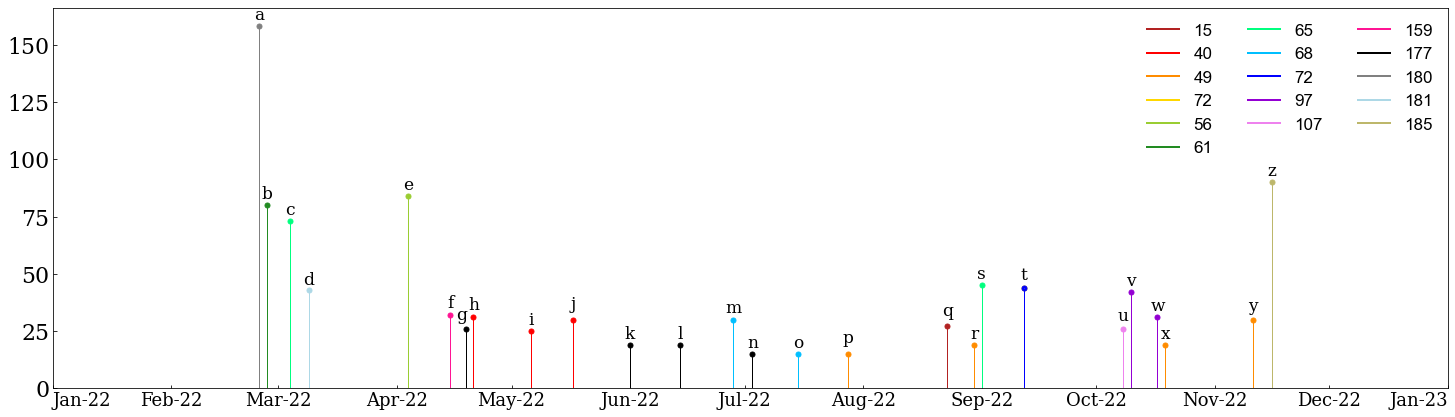

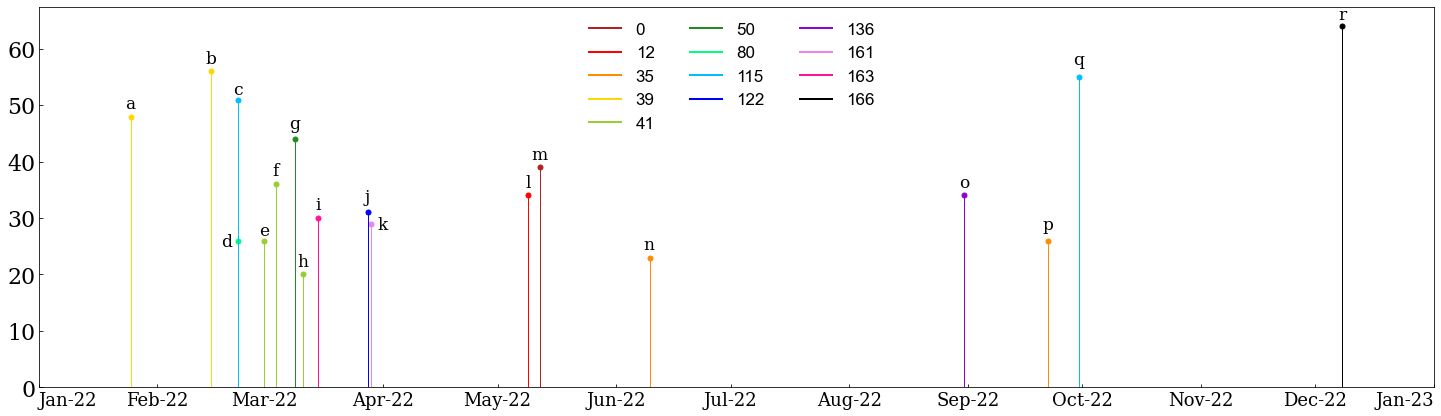

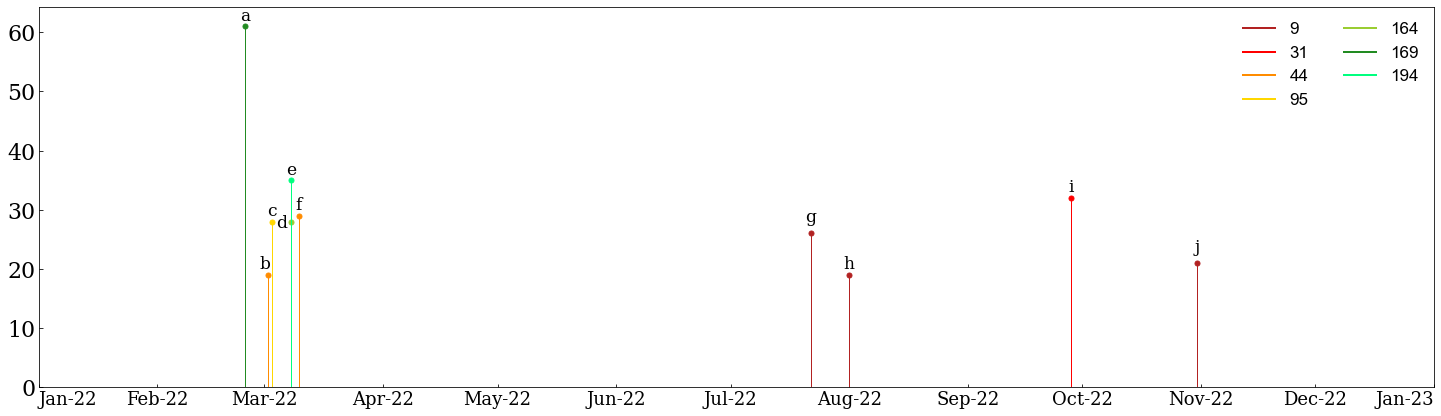

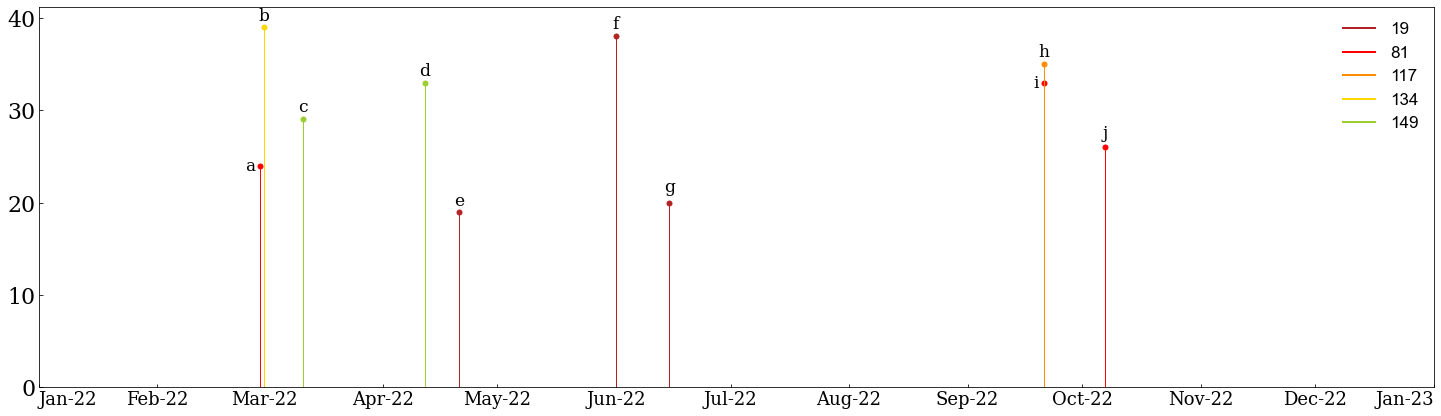

In [28]:
cats = ['bat','pol','pri','art']
label_columns = [3,3,2,1]
letter_positions = [
    [(dt.date(2022,2,24),161,'a','center'),
    (dt.date(2022,2,26),83,'b','center'),
    (dt.date(2022,3,4),76,'c','center'),
    (dt.date(2022,3,9),45.5,'d','center'),
    (dt.date(2022,4,4),87,'e','center'),
    (dt.date(2022,4,15),35.5,'f','center'),
    (dt.date(2022,4,18),30,'g','center'),
    (dt.date(2022,4,21),34.5,'h','center'),
    (dt.date(2022,5,6),28,'i','center'),
    (dt.date(2022,5,17),35,'j','center'),
    (dt.date(2022,6,1),22,'k','center'),
    (dt.date(2022,6,14),22,'l','center'),
    (dt.date(2022,6,28),33,'m','center'),
    (dt.date(2022,7,3),18,'n','center'),
    (dt.date(2022,7,15),18,'o','center'),
    (dt.date(2022,7,28),20,'p','center'),
    (dt.date(2022,8,23),32,'q','center'),
    (dt.date(2022,8,30),22,'r','center'),
    (dt.date(2022,9,1),48,'s','center'),
    (dt.date(2022,9,12),47.5,'t','center'),
    (dt.date(2022,10,8),29.5,'u','center'),
    (dt.date(2022,10,10),45,'v','center'),
    (dt.date(2022,10,17),34,'w','center'),
    (dt.date(2022,10,19),22,'x','center'),
    (dt.date(2022,11,11),34,'y','center'),
    (dt.date(2022,11,16),93,'z','center'),],
    [(dt.date(2022,1,25),49.5,'a','center'),
    (dt.date(2022,2,15),57.5,'b','center'),
    (dt.date(2022,2,22),52,'c','center'),
    (dt.date(2022,2,19),25,'d','center'),
    (dt.date(2022,3,1),27,'e','center'),
    (dt.date(2022,3,4),37.5,'f','center'),
    (dt.date(2022,3,9),46,'g','center'),
    (dt.date(2022,3,11),21.5,'h','center'),
    (dt.date(2022,3,15),31.5,'i','center'),
    (dt.date(2022,3,28),33,'j','center'),
    (dt.date(2022,4,1),28,'k','center'),
    (dt.date(2022,5,9),35.5,'l','center'),
    (dt.date(2022,5,12),40.5,'m','center'),
    (dt.date(2022,6,11),24.5,'n','right'),
    (dt.date(2022,8,31),35.5,'o','center'),
    (dt.date(2022,9,22),28,'p','center'),
    (dt.date(2022,9,30),57.2,'q','center'),
    (dt.date(2022,12,8),65.2,'r','center'),],
    [(dt.date(2022,2,24),62,'a','center'),
    (dt.date(2022,3,1),20,'b','center'),
    (dt.date(2022,3,3),29,'c','center'),
    (dt.date(2022,3,4),27,'d','left'),
    (dt.date(2022,3,8),36,'e','center'),
    (dt.date(2022,3,10),30,'f','center'),
    (dt.date(2022,7,22),28,'g','center'),
    (dt.date(2022,8,1),20,'h','center'),
    (dt.date(2022,9,28),33,'i','center'),
    (dt.date(2022,10,31),23,'j','center'),],
    [(dt.date(2022,2,24),23.5,'a','left'),
    (dt.date(2022,3,1),39.7,'b','center'),
    (dt.date(2022,3,11),29.8,'c','center'),
    (dt.date(2022,4,12),33.8,'d','center'),
    (dt.date(2022,4,21),19.7,'e','center'),
    (dt.date(2022,6,1),38.8,'f','center'),
    (dt.date(2022,6,15),21.2,'g','center'),
    (dt.date(2022,9,21),35.8,'h','center'),
    (dt.date(2022,9,19),32.4,'i','center'),
    (dt.date(2022,10,7),27,'j','center'),]
]
clist = [
        "firebrick",
        "red",
        "darkorange",
        "gold",
        "yellowgreen",
        "forestgreen",
        "springgreen",
        "deepskyblue",
        "blue",
        "darkviolet",
        "violet",
        "deeppink",
        "black",
        "grey",
        "lightblue",
        "darkkhaki"
    ]

for cat,pos,col in zip(cats,letter_positions,label_columns):
    fig3 = category_plot(df=data_df, chosen_cat=cat, tuples=pos, columns=col, clist=clist)
    fig3.savefig(os.path.join(ROOT_DIR, "figures","topic_counts", f"Category_plot_{cat}.svg"), format="svg", dpi=1000, bbox_inches="tight")
    


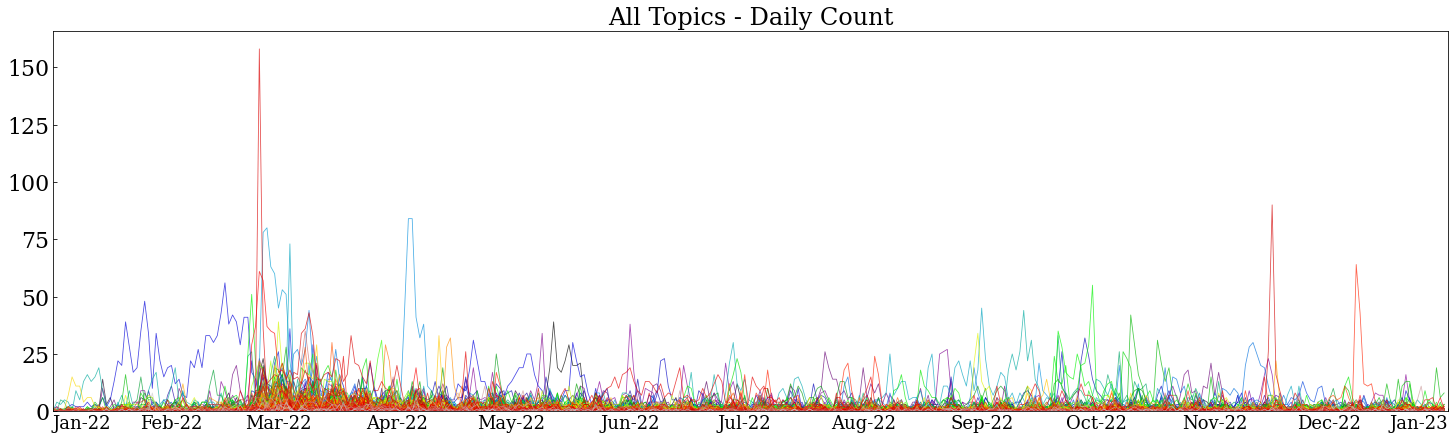

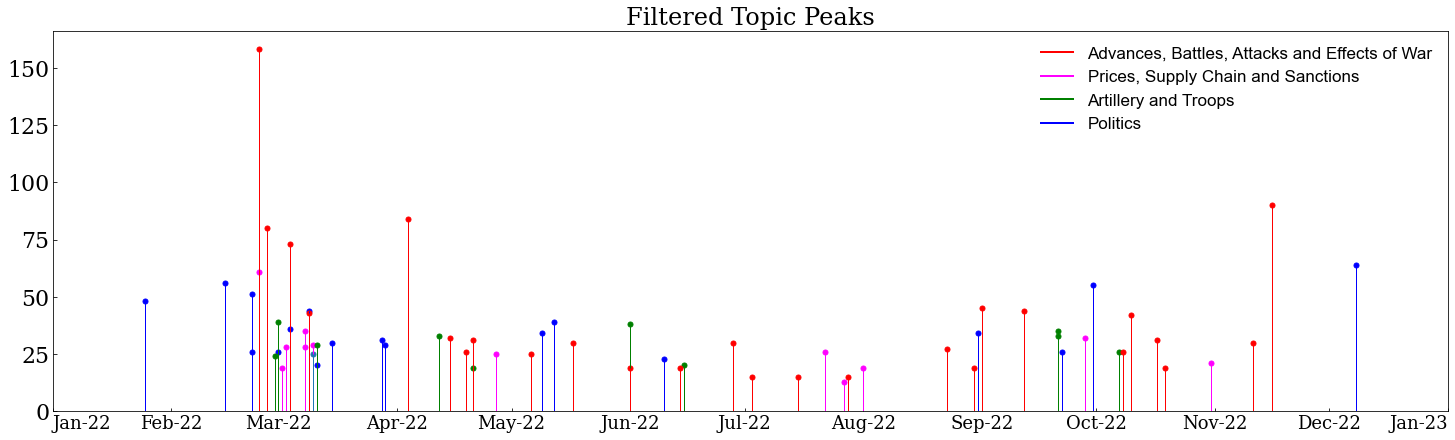

In [29]:
fig = multi_line_peaks_plot(data_df, f"All Topics - Daily Count", threshold=0)
fig.savefig(os.path.join(ROOT_DIR, "figures","topic_counts", f"Full_topic_count.svg"), format="svg", dpi=1000, bbox_inches="tight")

fig2 = filtered_multi_lines_peaks_plot(data_df)
fig2.savefig(os.path.join(ROOT_DIR, "figures","topic_counts", f"Filtered_topic_count.svg"), format="svg", dpi=1000, bbox_inches="tight")